In [271]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import pandas as pd
import datetime
import subprocess, sys, os
import copy

#os.system('for chr in `seq 1 22` X Y; do echo $chr; wget -qO- http://hgdownload.cse.ucsc.edu/goldenpath/hg38/chromosomes/chr$chr.fa.gz | gunzip -c - >> /mnt/HDD8TB/MicroSEC/source/hg38.fa; done')
#os.system('for chr in `seq 1 22` X Y; do echo $chr; wget -qO- http://hgdownload.cse.ucsc.edu/goldenpath/hg19/chromosomes/chr$chr.fa.gz | gunzip -c - >> /mnt/HDD8TB/MicroSEC/source/hg19.fa; done')



#pd.set_option('display.max_columns', 30)
#pd.set_option('display.max_rows', 30)

df = pd.read_excel("/mnt/HDD8TB/MicroSEC/source/MANOSEC_source.xlsx")

sort_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
              'chr21', 'chr22', 'chrX', 'chrY']
df.Chr = pd.Categorical(df.Chr, categories = sort_order)
df.sort_values(by=['Chr'], inplace=True)
df = df.reset_index()
df['palindrome'] = ""
df['search_seq'] = ""
df['search_hairpin_A'] = ""
df['search_hairpin_B'] = ""
df['possible_hairpin_A'] = 0
df['possible_hairpin_B'] = 0
df['possible_hairpin_C'] = 0
df['possible_hairpin_D'] = 0
df['possible_hairpin_E'] = 0
df['possible_hairpin_F'] = 0
df['possible_hairpin_G'] = 0
df['possible_hairpin_H'] = 0
df['score_20'] = 0
df['score_25'] = 0
df['score_30'] = 0
df['score_35'] = 0
df['score_40'] = 0
df['score_45'] = 0
df['score_50'] = 0
df['score_55'] = 0
df['score_60'] = 0
df_working = copy.deepcopy(df)
filename_BLAT = "/mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT_" + str(datetime.date.today()) + ".fa"
f = open(filename_BLAT, 'w', encoding='UTF-8')
records = SeqIO.parse('/mnt/HDD8TB/MicroSEC/source/hg38.fa', 'fasta')
j = 0
for record in records:
    if df_working.shape[0] > 0:
        if record.name == df_working.iloc[0].Chr:
            df_tmp = df_working[df_working['Chr'] == df_working.iloc[0].Chr]
            df_working = df_working[df_working['Chr'] != df_working.iloc[0].Chr]
            for i in range(df_tmp.shape[0]):
                if (j + 1) % 500 == 0:
                    print(str(j + 1) + " / " + str(df.shape[0]))
                ID = str(j)
                pos_start_1 = df_tmp.iloc[i].Pos - 31
                pos_start_2 = df_tmp.iloc[i].Pos + len(df_tmp.iloc[i].Ref) - 1
                pos_end_1 = df_tmp.iloc[i].Pos - 1
                pos_end_2 = df_tmp.iloc[i].Pos + len(df_tmp.iloc[i].Ref) + 29
                seq_tmp = (str(record.seq[pos_start_1:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_end_2])).lower()
                f.write('>' + ID + '\n')
                f.write(seq_tmp + '\n')
                df.loc[j, 'palindrome'] = (str(record.seq[pos_end_1 - 200:pos_end_1]) + df_tmp.iloc[i].Ref + str(record.seq[pos_start_2:pos_start_2 + 200])).lower()
                df.loc[j, 'search_seq'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df.loc[j, 'search_hairpin_A'] = (str(record.seq[pos_end_1 - 5:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 5])).upper()
                df.loc[j, 'search_hairpin_B'] = (str(record.seq[pos_end_1 - 10:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 10])).upper()
                j = j + 1
print(str(j) + " / " + str(df.shape[0]))
f.close()
os.system('blat -stepSize=5 -repMatch=2253 -minScore=20 -minIdentity=0 /mnt/HDD8TB/MicroSEC/source/hg38.fa /mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT_2021-06-20.fa /mnt/HDD8TB/MicroSEC/source/output.pslx -out=pslx -t=dna -q=dna')
os.system('sed "1,5d" /mnt/HDD8TB/MicroSEC/source/output.pslx > /mnt/HDD8TB/MicroSEC/source/output.tsv')

result_BLAT = pd.read_csv('/mnt/HDD8TB/MicroSEC/source/output.tsv', delimiter='\t', header=None)

for i in range(df.shape[0]):
    if (i + 1) % 500 == 0:
        print(str(i + 1) + " / " + str(df.shape[0]))
    df.loc[i, 'possible_hairpin_A'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -5, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_F'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_G'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -5, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_H'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_20'] = df.loc[i, 'score_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_25'] = df.loc[i, 'score_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_30'] = df.loc[i, 'score_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_35'] = df.loc[i, 'score_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_40'] = df.loc[i, 'score_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_45'] = df.loc[i, 'score_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_50'] = df.loc[i, 'score_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_55'] = df.loc[i, 'score_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_60'] = df.loc[i, 'score_60'] + 1
print(str(i + 1) + " / " + str(df.shape[0]))

df.to_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed.xlsx')

X = df.loc[:, ("%Alt", "possible_hairpin_A", "possible_hairpin_B", "possible_hairpin_C", "possible_hairpin_D", "possible_hairpin_E", "possible_hairpinF", "possible_hairpin_G", "possible_hairpin_H", "score_20", "score_25", "score_30", "score_35", "score_40", "score_45", "score_50", "score_55", "score_60")]
X["SNV"] = df.loc[:, ("Mut_type")].str.contains("snv").astype(int)
X["DEL"] = df.loc[:, ("Mut_type")].str.contains("del").astype(int)
X["INS"] = df.loc[:, ("Mut_type")].str.contains("ins").astype(int)
X["bases"] = df.loc[:, ("Mut_type")].str.split("-", expand=True)[0].astype(int)

y = (df.loc[:, "msec_filter_1234"]).astype(int)

500 / 7004
1000 / 7004
1500 / 7004
2000 / 7004
2500 / 7004
3000 / 7004
3500 / 7004
4000 / 7004
4500 / 7004
5000 / 7004
5500 / 7004
6000 / 7004
6500 / 7004
7000 / 7004
7004 / 7004
500 / 7004
1000 / 7004
1500 / 7004
2000 / 7004
2500 / 7004
3000 / 7004
3500 / 7004
4000 / 7004
4500 / 7004
5000 / 7004
5500 / 7004
6000 / 7004
6500 / 7004
7000 / 7004
7004 / 7004


In [273]:
X = df.loc[:, ("%Alt", "possible_hairpin_A", "possible_hairpin_B", "possible_hairpin_C", "possible_hairpin_D", "possible_hairpin_E", "possible_hairpin_F", "possible_hairpin_G", "possible_hairpin_H", "score_20", "score_25", "score_30", "score_35", "score_40", "score_45", "score_50", "score_55", "score_60")]
X["SNV"] = df.loc[:, ("Mut_type")].str.contains("snv").astype(int)
X["DEL"] = df.loc[:, ("Mut_type")].str.contains("del").astype(int)
X["INS"] = df.loc[:, ("Mut_type")].str.contains("ins").astype(int)
X["bases"] = df.loc[:, ("Mut_type")].str.split("-", expand=True)[0].astype(int)

y = (df.loc[:, "msec_filter_1234"]).astype(int)

In [274]:
# 訓練データとテストデータに分割するメソッドのインポート
from sklearn.model_selection import train_test_split 
# 訓練データ・テストデータへ6:4の比でランダムに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25) 
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
classifier = LogisticRegression() # 分類器の生成
classifier.fit(X_train, y_train) #学習
import timeit # 実行時間を計測するためのライブラリ
timeit.timeit(lambda: classifier.fit(X_train, y_train), number=1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0768859019735828

In [275]:
classifier.score(X_train,y_train)

0.9289929564058633

In [276]:
classifier.score(X_test,y_test)

0.9366076527698458

In [277]:
y_pred = classifier.predict(X_test)

In [278]:
from sklearn.metrics import confusion_matrix # 混同行列を計算するメソッド
# 予測結果と、正解（本当の答え）がどのくらい合っていたかを表す混同行列
pd.DataFrame(confusion_matrix(y_pred, y_test), 
             index=['predicted 0', 'predicted 1'], columns=['real 0', 'real 1'])

,real 0,real 1
predicted 0,1139,92
predicted 1,19,501


In [279]:
y_proba = classifier.predict_proba(X_test)

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline

AUC curve : 0.965838


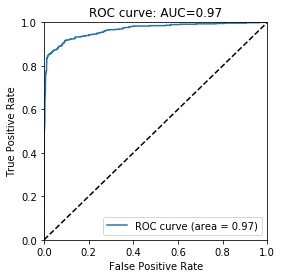

In [281]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# AUCスコアを出す
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)

# ROC curve を描く
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [282]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
 
from sklearn.model_selection import train_test_split, GridSearchCV
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.2)
clf = RFC(verbose=True,       # 学習中にログを表示します。この指定はなくてもOK
          n_jobs=-1,          # 複数のCPUコアを使って並列に学習します。-1は最大値。
          random_state=2525)  # 乱数のシードです。
clf.fit(train_images, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=2525, verbose=True,
            warm_start=False)

In [283]:
print(f"acc: {clf.score(test_images, test_labels)}")

acc: 0.9443254817987152


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [284]:
search_params = {
    'n_estimators'      : [5, 10, 20, 30, 50, 100, 300],
    'max_features'      : [3, 5, 10],
    'random_state'      : [2525],
    'n_jobs'            : [1],
    'min_samples_split' : [10, 20, 30, 40, 50, 100],
    'max_depth'         : [10, 20, 30, 40, 50, 100]
}

gs = GridSearchCV(RFC(),           # 対象の機械学習モデル
                  search_params,   # 探索パラメタ辞書
                  cv=3,            # クロスバリデーションの分割数
                  verbose=True,    # ログ表示
                  n_jobs=-1)       # 並列処理
gs.fit(train_images, train_labels)
 
print(gs.best_estimator_)

Fitting 3 folds for each of 2100 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 3978 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 5978 tasks      | elapsed:  1.0min


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=2525, verbose=0,
            warm_start=False)


[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:  1.1min finished


In [285]:
print(f"acc: {gs.score(test_images, test_labels)}")

acc: 0.960028551034975


AUC curve : 0.982671


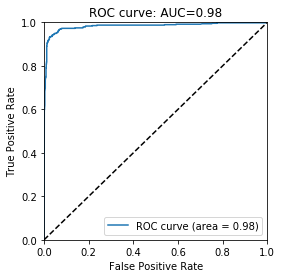

In [286]:
y_proba = gs.predict_proba(test_images)
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# AUCスコアを出す
fpr, tpr, thresholds = roc_curve(test_labels, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)

# ROC curve を描く
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [287]:
y_pred = classifier.predict(test_images)
from sklearn.metrics import confusion_matrix # 混同行列を計算するメソッド
# 予測結果と、正解（本当の答え）がどのくらい合っていたかを表す混同行列
pd.DataFrame(confusion_matrix(y_pred, test_labels), 
             index=['predicted 0', 'predicted 1'], columns=['real 0', 'real 1'])

,real 0,real 1
predicted 0,907,71
predicted 1,21,402


0

In [289]:
records = SeqIO.parse('/mnt/HDD8TB/MicroSEC/source/hg19.fa', 'fasta')
j = 0
for record in records:
    print(record)


ID: chr1
Name: chr1
Description: chr1
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')
ID: chr2
Name: chr2
Description: chr2
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')
ID: chr3
Name: chr3
Description: chr3
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')
ID: chr4
Name: chr4
Description: chr4
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')
ID: chr5
Name: chr5
Description: chr5
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')
ID: chr6
Name: chr6
Description: chr6
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')
ID: chr7
Name: chr7
Description: chr7
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')
ID: chr8
Name: chr8
Description: chr8
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN